In [19]:
#Load libraries (delete ones not used)
library(tidyverse)
library(rsample)
library(mltools)
library(caret)
library(reshape)
library(GGally)
library(corrplot)
library(glmnet)
library(infer)
library(leaps)

## Prediction of Wine Quality
**STAT 301 Group 2:** Yuechang Liu, Anne Nguyen, Maggie Ruan <br>
**Date:** Dec 16, 2023

### Introduction

Wine consumers often wonder how to select a bottle of quality wine. Thach showed that consumers seek the advice of wine experts, followed by other wine quality such as geographical origin, and age (Thach, 2008). Depending on the quality proxy studied, significant correlations between quality, volatiles and elements were found (Hopfer et al., 2015). Since there were previouse reported literature mentioning the significance and correlation between wine quality and different elements, our group foud a data set that allowed us to further investigate. 

The data set selected is about red and white variants of the Portuguese "Vinho Verde" wine and is found at the UCI Machine Learning Repository (Cortez et al., 2009). The data set was created by Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis. As the data is separated into two files by wine colour, our group decided to only focus on red wine based on our interest. 

The data were collected from May/2004 to February/2007 using only protected designation of origin samples that were tested at the official certification entity (CVRVV). Due to privacy and logistic issues, only physicochemical (inputs) and sensory (output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.). The data were recorded by a computerized system (iLab), which automatically manages the process of wine sample testing from producer requests to laboratory and sensory analysis (Cortez et al., 2009).

There are 12 recorded variables, 11 of which are are physicochemical qualities of the wine
thay are contineous variables based on physicochemical tests:
   >+ 1 - fixed acidity
   >+ 2 - volatile acidity
   >+ 3 - citric acid
   >+ 4 - residual sugar
   >+ 5 - chlorides
   >+ 6 - free sulfur dioxide
   >+ 7 - total sulfur dioxide
   >+ 8 - density
   >+ 9 - pH
   >+ 10 - sulphates
   >+ 11 - alcohol

For the physicochemical qualities, the majority of the variables refer to the amount of the named variable in the wine while pH is a measure of the acidity/basicity of the wine, density is a measure of the concentration of the wine, fixed acidity is the amount of acids originating from the grapes, and volatile acidity refers to the amount of acid from microbial metabolism. 
   >+ 12 - quality (score between 0 and 10)

The data was gathered based on sensory data that each sample was evaluated by a minimum of three sensory assessors (using blind tastes), grade the wine quality between 0 (very bad) and 10 (very excellent) and final score was given by the median of these evaluations.

Thus, the random variable of interest is the wine quality score. Exploratory data analysis would include all physicochemical variables in the data set as explanatory variables and depending on whether there are high correlation, multicollinearity, a subset of those variables may be selected as the explanatory variables in the main analysis. Using the data, we would like to build a regression model that can predict the quality rating of red wine based on its chemical properties with the highest accuracy. As a result, this project aims to answer:
>+ Using the model selection method, how well do the selected explanatory variables predict the wine quality?

### Exploratory Data Analysis

First, the data is imported and named as `wine_red`. Counts of observation and missing values were examied to clean the data into a tidy format.

In [20]:
#Read the dataset from the web into R
wine_red <- read_delim("https://raw.githubusercontent.com/a-nguyen-1/STAT301-Project/main/data/winequality-red.csv")
head(wine_red)

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


Table 1. The first few rows from the red wine data set.

In [21]:
#Examine the counts of observations, levels, missing values
data.frame(Total_observations = nrow(wine_red),
           Missing_values = sum(is.na(wine_red)),
           Number_of_variables = ncol(wine_red))

Total_observations,Missing_values,Number_of_variables
<int>,<int>,<int>
1599,0,12


Table 2. Information on the size of the data set and missing values.

In [22]:
#Summary statistics of quantitative variables
wine_summary <- as.data.frame(sapply(wine_red, summary))
wine_summary

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Min.,4.600000,0.1200000,0.0000000,0.900000,0.01200000,1.00000,6.00000,0.9900700,2.740000,0.3300000,8.40000,3.000000
1st Qu.,7.100000,0.3900000,0.0900000,1.900000,0.07000000,7.00000,22.00000,0.9956000,3.210000,0.5500000,9.50000,5.000000
Median,7.900000,0.5200000,0.2600000,2.200000,0.07900000,14.00000,38.00000,0.9967500,3.310000,0.6200000,10.20000,6.000000
Mean,8.319637,0.5278205,0.2709756,2.538806,0.08746654,15.87492,46.46779,0.9967467,3.311113,0.6581488,10.42298,5.636023
3rd Qu.,9.200000,0.6400000,0.4200000,2.600000,0.09000000,21.00000,62.00000,0.9978350,3.400000,0.7300000,11.10000,6.000000
Max.,15.900000,1.5800000,1.0000000,15.500000,0.61100000,72.00000,289.00000,1.0036900,4.010000,2.0000000,14.90000,8.000000


Table 3. Distribution and scale of each of the 12 variables in the red wine data set.

>Number of observations: There are a total of 1599 observations without missing values. We decided to treate all 12 variables as contineous variables with quality as the response variable. The quantitative variables appear to be on different scales.

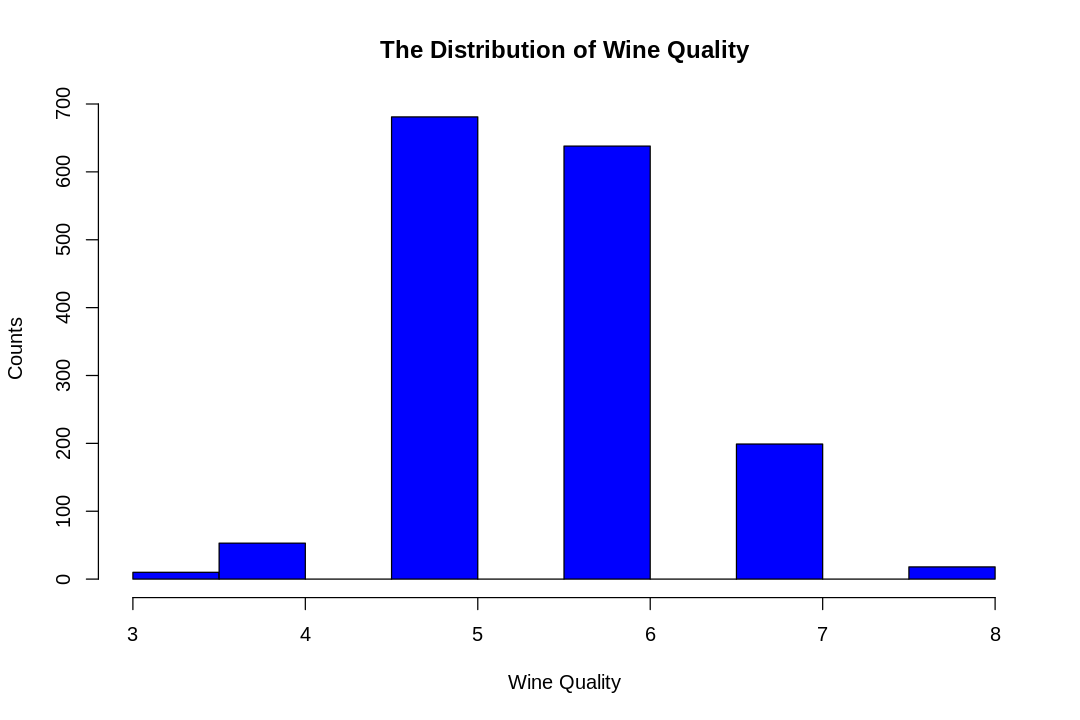

In [23]:
#Distribution of quality
options(repr.plot.width = 9, repr.plot.height = 6)
hist(wine_red$quality, col = "blue", main = "The Distribution of Wine Quality", 
     xlab = "Wine Quality", ylab = "Counts")

Figure 1. Count distributions of wine quality scores in the red wine data set.

>The histogram is not normally distributed. The majority of wine were distributed in quality 5 and 6 with counts in the range of 600 to 700. 

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”


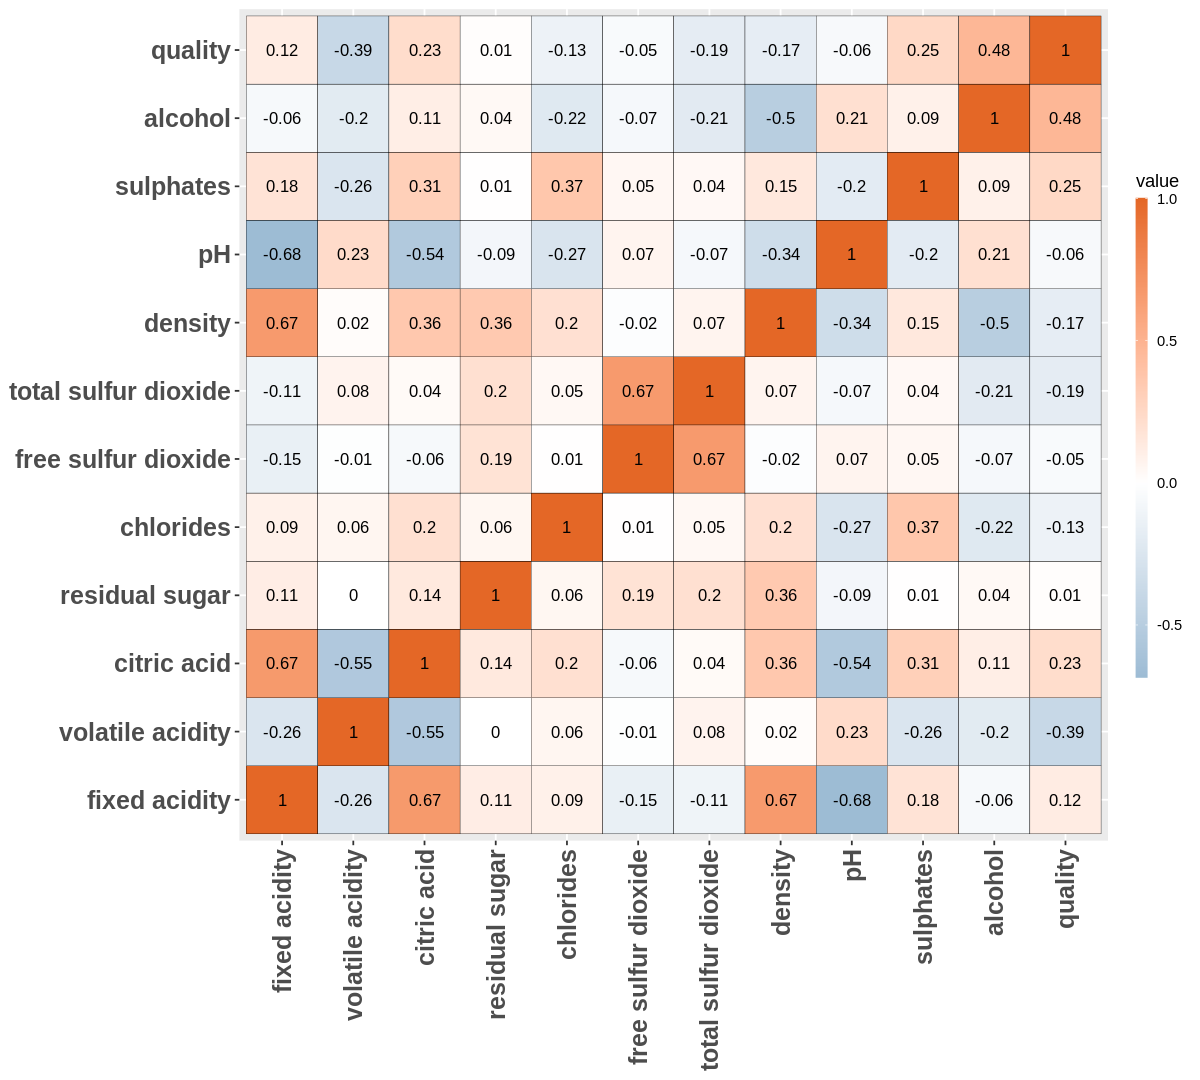

In [24]:
#Correlation plot to examine the relationship btw variables
cor_matrix = cor(subset(wine_red))
melted = melt(cor_matrix)

options(repr.plot.width = 10, repr.plot.height = 9)

ggplot(melted)+
    geom_tile(aes(X1, X2, fill = value), colour = "black")+
    geom_text(aes(X1, X2, label = round(value, 2)), colour = "black", size = 3.5)+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
          axis.text = element_text(size = 15, face = "bold"),
          axis.title = element_blank()) +
    scale_fill_gradient2(low = "#6D9EC1", high = "#E46726")+
    guides(fill = guide_colourbar(barwidth = 0.5, barheight = 20))

Figure 2. Plot of the correlations between all variables in the data set.

>By calling cor() and melt() function, we are able to visualize the correlation matrix, displaying the pairwise correlations between variables in the wine dataset. 

>We see there is no strong correlation between the response variable, quality, and the potential predictor variables which is not surprising as quality is a subjective measure as described in the introduction. For the correlations between quality and the predictors, alcohol has the strongest correlation with a value of 0.48 while residual sugar is the weakest with a value of 0.01. There appears to be multicollinearity between some potential predictor variables such as total sulfur dioxide and free sulfur dioxide with a correlation of 0.67. The multicollinearity of the predictors would need to be taken into consideration when selecting the predictor variables for the model.

### Methods: Plan

>First, the data was split into training and testing subset with 70% of the data in the training set and 30% in the testing set. A seed using the number 301 was used for reproducible results. We assumed the quality score to be continuous due to the complexity of the regression model when quality is instead considered as a class.

In [25]:
#Create training/testing splits of data
set.seed(301)
wine_split <- initial_split(wine_red, prop = 0.70, strata = quality)
training_wine <- training(wine_split)
testing_wine <- testing(wine_split)
head(training_wine)

fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.700,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.660,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5
7.5,0.500,0.36,6.1,0.071,17,102,0.9978,3.35,0.80,10.5,5
6.7,0.580,0.08,1.8,0.097,15,65,0.9959,3.28,0.54,9.2,5
7.5,0.500,0.36,6.1,0.071,17,102,0.9978,3.35,0.80,10.5,5
5.6,0.615,0.00,1.6,0.089,16,59,0.9943,3.58,0.52,9.9,5


Table 4. The first few rows from the training data split.

>Since the aim of the research is prediction, it is preferable to aim for lower mean squared error (MSE) for better prediction performance. We examined the performance of ordinary least squares (OLS), backward selection, ridge and lasso regression models by the MSE in 10-fold cross validation. As the models in OLS and backward selection use linear models, we assumed a linear relationship exists between the predictors and response variables, observations are independent, normally distributed, and there is constant variance for the residuals. Assumptions about ridge or lasso regression have not been covered however a limitation is that there is a loss of interpretability of the coefficients as the effect of each predictor by introducing bias into the models. As well, multicollinearity may be address in some of these prediction models by variable selection or in the regularized methods.

>Next, we conducted backward selection on the training data and examine adjusted $R^2$ to select the model.

In [26]:
wine_backward_sel <- regsubsets(
  quality ~ .,
  data = training_wine,
  nvmax = ncol(training_wine) - 1,
  method = "backward"
)

wine_bwd_summary <- summary(wine_backward_sel)

# Creating a dataframe with the summary metrics
wine_bwd_summary_df <- data.frame(
    n_input_variables = 1:(ncol(training_wine) - 1),
    RSQ = wine_bwd_summary$rsq,
    RSS = wine_bwd_summary$rss,
    ADJ.R2 = wine_bwd_summary$adjr2
)

# View the summary dataframe
wine_bwd_summary_df

n_input_variables,RSQ,RSS,ADJ.R2
<int>,<dbl>,<dbl>,<dbl>
1,0.2267731,571.3933,0.2260796
2,0.3118560,508.5193,0.3106206
3,0.3432114,485.3486,0.3414410
4,0.3490063,481.0662,0.3466646
5,0.3563986,475.6036,0.3535021
6,0.3644191,469.6766,0.3609835
7,0.3660317,468.4850,0.3620301
8,0.3669389,467.8146,0.3623681
9,0.3674555,467.4328,0.3623129


Table 5. $R^2$, residual sum of square, and adjusted $R^2$ of the selected variables for different model sizes.

>The model with 10 variables (n_input_variables = 10) appears to be a good candidate with the highest adjusted R-squared and includes the predictors: Fixed Acidity, Volatile Acidity, Citric Acid, Residual Sugar, Chlorides, Free Sulfur Dioxide, Total Sulfur Dioxide, pH, Sulphates, Alcohol.

>Next, 10-fold cross validation was conducted on ordinary least squares, backward selection, ridge and lasso regression models and the MSE is compiled into a table for comparison.

In [27]:
set.seed(301)

#CV for OLS and backward selection models
train_control <- trainControl(method = "cv", number = 10)
cv_ols_model <- train(quality ~ ., data = training_wine, method = "lm", 
                      trControl = train_control)
training_wine_back <- training_wine %>% select(-density)
cv_back_model <- train(quality ~ ., data = training_wine_back, method = "lm", 
                       trControl = train_control)

#CV for ridge and lasso regression
model_Y_matrix  <- as.matrix(training_wine$quality)
model_X_matrix <- model.matrix(~ ., data = training_wine %>% select(-quality))
cv_ridge_model <- cv.glmnet(x = model_X_matrix, y = model_Y_matrix, alpha = 0, nfolds = 10)
cv_lasso_model <- cv.glmnet(x = model_X_matrix, y = model_Y_matrix, alpha = 1, nfolds = 10)

#MSE of CV results
data.frame(Model = c("OLS", "Backward Selection", "Ridge Regression", "Lasso Regression"),
           MSE = c(cv_ols_model$results$RMSE^2,cv_back_model$results$RMSE^2, 
                   min(cv_ridge_model$cvm), min(cv_lasso_model$cvm)))

Model,MSE
<chr>,<dbl>
OLS,0.4273871
Backward Selection,0.4294779
Ridge Regression,0.4278754
Lasso Regression,0.4271319


Table 6. 10-fold cross validation mean squared errors for OLS, backward selection, ridge regression, and lasso regression models.

In [28]:
#Using test dataset for the result
min_lam <- cv_lasso_model$lambda.min
final_model <- glmnet(x = model_X_matrix, y = model_Y_matrix, alpha = 1, lambda = min_lam)
final_model$beta

test_X_matrix <- model.matrix(~ ., data = testing_wine %>% select(-quality))
predictions <- predict(final_model, test_X_matrix)
mse <- mean((testing_wine$quality - predictions)^2)

12 x 1 sparse Matrix of class "dgCMatrix"
                                 s0
(Intercept)             .          
`fixed acidity`         0.016857327
`volatile acidity`     -1.004427782
`citric acid`          -0.163405813
`residual sugar`        0.015176375
chlorides              -1.663613796
`free sulfur dioxide`   0.002627905
`total sulfur dioxide` -0.002624981
density                 .          
pH                     -0.484597806
sulphates               1.038832033
alcohol                 0.304377452

>Based on a 10-fold cross validation of various models, we selected lasso regression to fit our prediction model as it had the lowest MSE. The method selected 10 of the 11 predictor variables (all except density) with an optimal lambda of 0.00306. Our model was used to predict the wine quality of the testing set and the MSE was found to be 0.42032.

### Discussion

In our group project, we focused on predicting wine quality using statistical models. We compared several models, including Ordinary Least Squares, Backward Selection, Ridge Regression, and Lasso Regression, using Mean Squared Error (MSE) as our main measure of accuracy. Our analysis showed that Lasso Regression performed the best, with the lowest MSE.

The Lasso model helped us identify the most important factors affecting wine quality. For example, it showed that volatile acidity negatively impacts quality, while alcohol has a positive effect. This was useful because it gave us insights into which aspects of wine production could be adjusted to improve quality.

We also found that the Lasso model did well in predicting the quality of wines in our test dataset, as indicated by a low MSE. This result was encouraging, as it suggested that our model could be reliable and useful in real-world situations. Overall, our project provided valuable insights into wine quality prediction and could have practical applications in the wine industry.

Based on our understanding of wine chemistry, we anticipated that factors like alcohol, acidity, and sulphates would significantly influence wine quality. Our results, particularly from the Lasso Regression model, largely aligned with these expectations.

Interestingly, the Lasso model's decision to exclude 'density' as a significant predictor was somewhat unexpected. We initially thought that density might play a more prominent role in determining wine quality. However, the model's ability to perform feature selection helped us understand that other factors were more crucial.

The fact that Lasso Regression emerged as the most effective model with the lowest MSE was in line with our expectations. We anticipated that a model capable of both regularization and feature selection would be advantageous in handling a dataset with multiple variables.

Based on the current model, we could improve the model by exploring additional features or transformations of existing features that could better capture the nuances of wine quality. For instance, we could create interaction terms between variables.

On the other hand, the model could be improved by grouping wine qualities 3, 4, and 5 as 'low quality' and 6, 7, 8 as 'high quality' to transform the response variable into a binary variable. Then use lasso in conjunction with logistic regression to assess how well the model generalizes to new data. When employing logistic regression, it assumes a linear relationship between the log-odds of the outcome and the predictor variables, with the residual to be normally distributed, the errors are independentand and the predictor variables should not exhibit high correlation with each other. The model would imploy $\lambda$ with one standard error. Ultimately, using ROC to access how well the model perform on testing data set.

Regarding wine quality, future research could be determining wine making methods to obtain optimal levels of these physicochemical properties. As well, when aiming for higher wine quality, there may be issues with the quality and cost trade-off for both wine companies and consumers therefore optimizations in this aspect may need to be examined. Another application could be in predicting the reception of various new wine products and adjusting logistics and budgeting based on the predictions. Overall, the research contributes to better understanding what variables in wine may improve its quality and possible further applications in the wine industry.

### References

Hopfer, H., Nelson, J., Ebeler, S. E., & Heymann, H. (2015). Correlating wine quality indicators to chemical and sensory measurements. Molecules (Basel, Switzerland), 20(5), 8453–8483. https://doi.org/10.3390/molecules20058453<br>

Thach L. How American Consumers Select Wine. Wine Bus. Mon. 2008;15:66–71.

Cortez,Paulo, Cerdeira,A., Almeida,F., Matos,T., and Reis,J.. (2009). Wine Quality. UCI Machine Learning Repository. https://doi.org/10.24432/C56S3T.